In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

In [149]:
# importando o dataframe
dados_completos = pd.read_csv('Dataset/airline-passengers.csv')

In [150]:
dados_completos.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [151]:
dados_completos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [152]:
# ajustado o dataframe, incluindo uma coluna de data 
dados_completos['datetime'] = pd.to_datetime(dados_completos['Month'])

In [153]:
# verificando as caracteristica do dataframe
dados_completos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    object        
 1   Passengers  144 non-null    int64         
 2   datetime    144 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 3.5+ KB


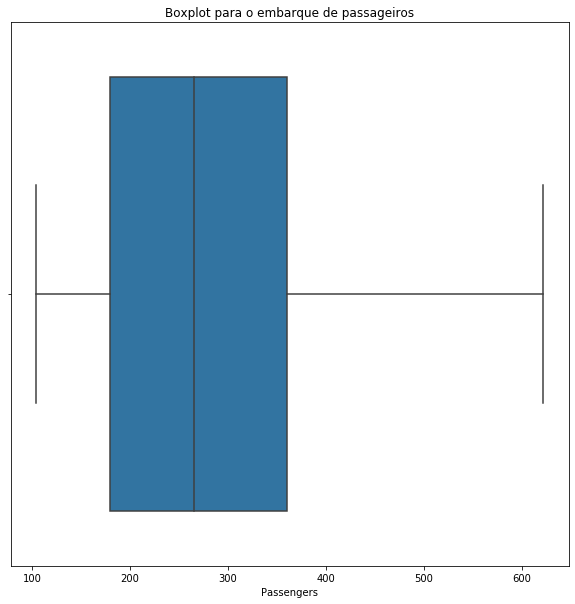

In [154]:
# verificando se existe outliers 
plt.figure(figsize = (10, 10))
g = sns.boxplot(dados_completos['Passengers'])
g.set_title('Boxplot para o embarque de passageiros')
plt.show()

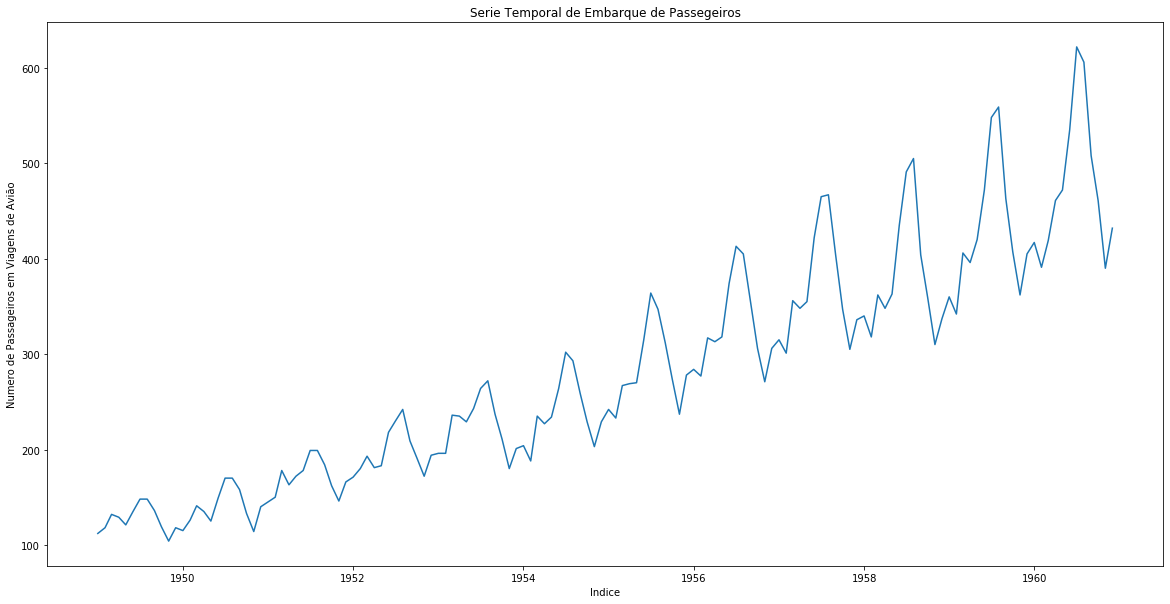

In [155]:
# plotando o grafico de variação do numero de passageiros no periodo
plt.figure(figsize = (20, 10))
g = sns.lineplot(x = dados_completos['datetime'], y = dados_completos['Passengers'])
g.set_title('Serie Temporal de Embarque de Passegeiros')
g.set_xlabel('Indice')
g.set_ylabel('Numero de Passageiros em Viagens de Avião')
plt.show()

In [156]:
# realizando a decomposição da serie temporal
from statsmodels.tsa.seasonal import seasonal_decompose

In [157]:
# modificando o indice para ser temporal
df_serie_temporal = dados_completos.set_index('datetime')

In [158]:
df_serie_temporal.head()

,Month,Passengers
datetime,,
1949-01-01,1949-01,112
1949-02-01,1949-02,118
1949-03-01,1949-03,132
1949-04-01,1949-04,129
1949-05-01,1949-05,121


In [159]:
# verifica as colunas existentes
df_serie_temporal.columns

Index(['Month', 'Passengers'], dtype='object')

In [160]:
# realiza o drop da coluna 'month'
df_serie_temporal.drop('Month', axis = 1, inplace = True)

In [161]:
df_serie_temporal.head()

,Passengers
datetime,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [162]:
# realiando a construção do modelo de decomposição da seria temporal
decomposicao_aditiva = seasonal_decompose(df_serie_temporal, model = 'aditive', extrapolate_trend = 'freq') # aplica o modelo de decomposição aditiva

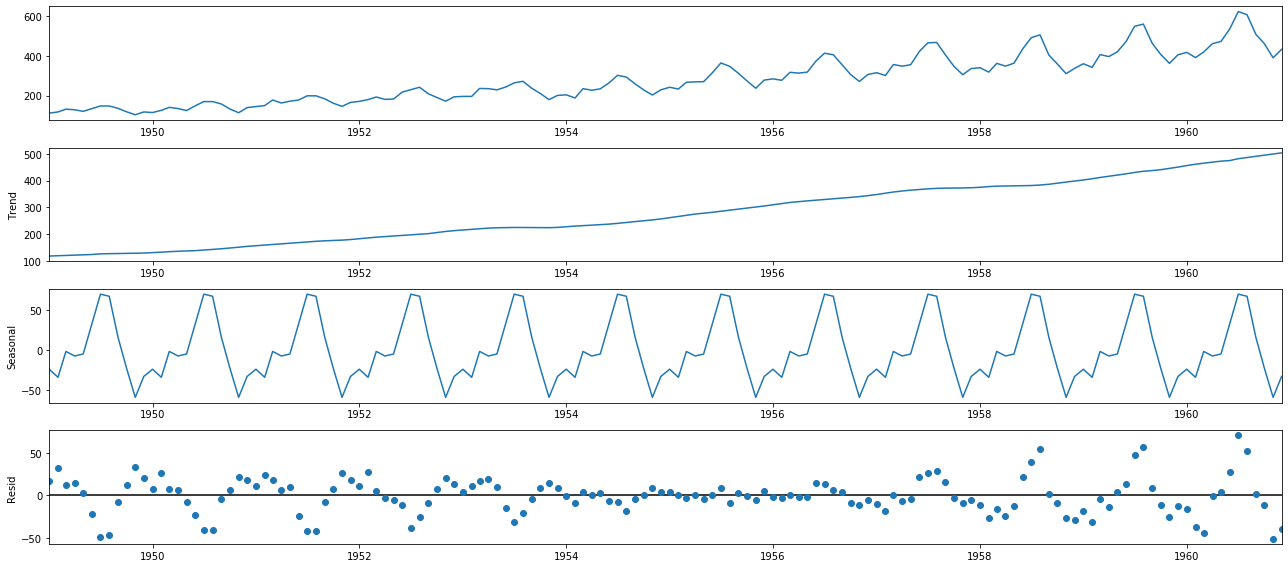

In [163]:
# realiza o plot da descomposição
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
fig = decomposicao_aditiva.plot()
plt.show()

In [164]:
# testando a estacionariedade da serie temporal
from statsmodels.tsa.stattools import adfuller

In [165]:
# aplica o teste de ADF
# para o teste de ADF a hipotese nula é que existe, pelo menos, uma raiz negativa da serie temporal
resultado_ADF = adfuller(df_serie_temporal.Passengers.values, autolag = 'AIC')

In [166]:
print('ADF Valor', resultado_ADF[1]) 

ADF Valor 0.9918802434376409


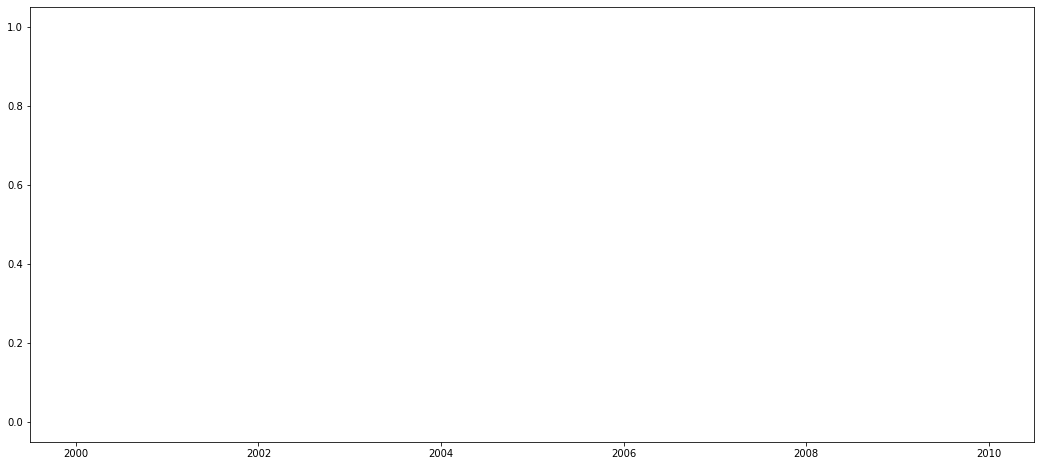

In [167]:
# retirando a tendencia da serie temporal
detrended = df_serie_temporal - decomposicao_aditiva.trend
plt.plot(detrended)
plt.show()

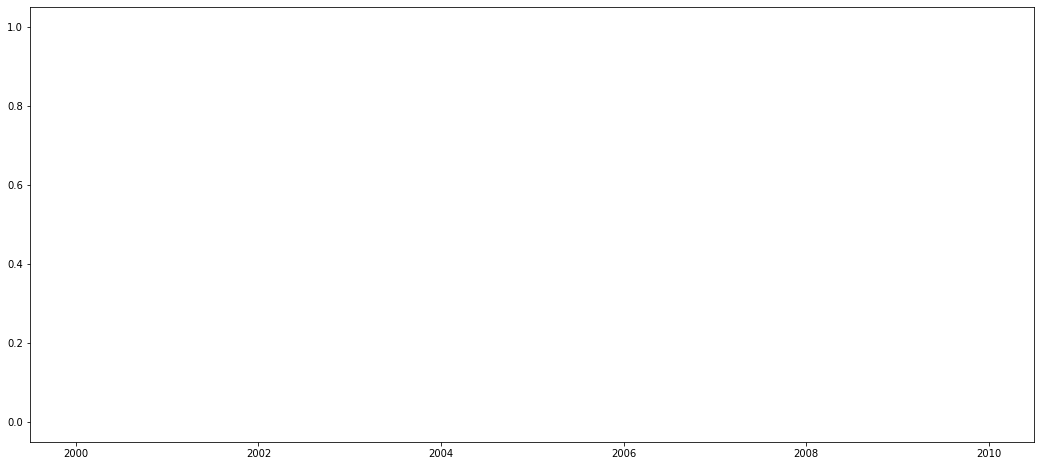

In [168]:
# retirando a sasonalidade da serie temporal
deseasonalized = df_serie_temporal - decomposicao_aditiva.seasonal
plt.plot(deseasonalized)
plt.show()

In [169]:
# realizando a analise de autocorrelação nos dados
from statsmodels.graphics.tsaplots import plot_acf

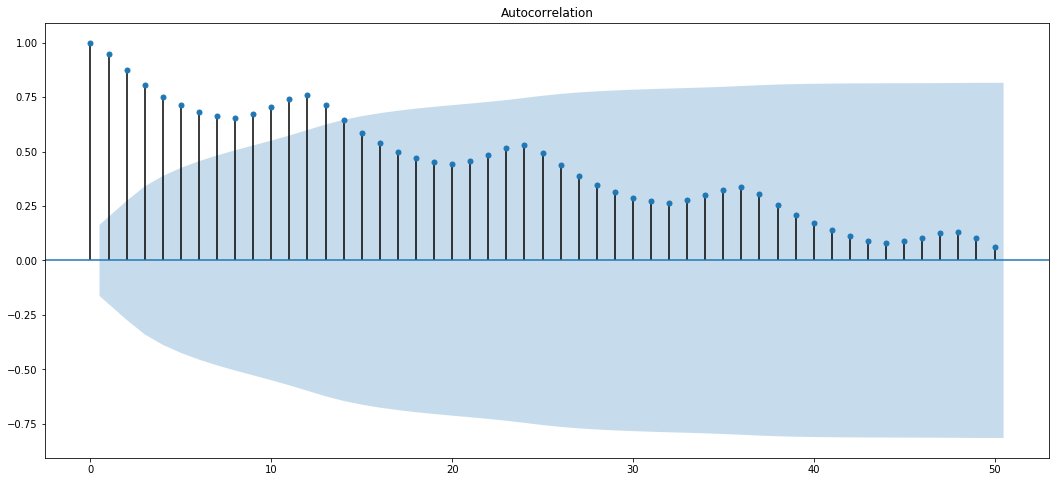

In [170]:
plot_acf(df_serie_temporal, lags = 50)
plt.show()

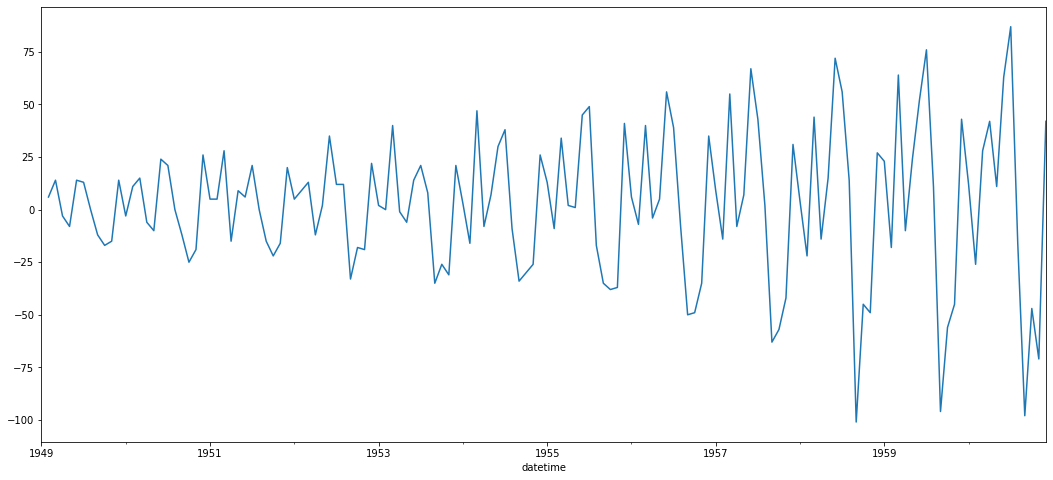

In [171]:
# transformando a serie em estacionaria
df_serie_temporal['Passengers_diff'] = df_serie_temporal['Passengers'] - df_serie_temporal['Passengers'].shift(1) # aplica o primeiro shift (derivada para tempo discreto)
df_serie_temporal['Passengers_diff'] = df_serie_temporal['Passengers_diff'].dropna() # retira os valores nulos
df_serie_temporal['Passengers_diff'].plot()
plt.show()

In [172]:
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [173]:
# volta o dataset para o estado normal
serie_passageiros = df_serie_temporal['Passengers'].values

In [174]:
# normalização do dataframe, necessário para que os algoritmos possem ter um comportamento mais previsivel
scaler = MinMaxScaler(feature_range = (0, 1)) # cria o objeto que realiza a normalizção dos dados por meio dos valores minimos e maximos
dataset = scaler.fit_transform(serie_passageiros.reshape(-1, 1)) # aplica a escala

In [175]:
# divide o dataset em dados de treino e teste
train_size = int(len(dataset) * 0.67) # encontra o valor maximo para treinamento
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


In [176]:
# cria a matriz necessária para a entreda dos dados
def create_database(dataset, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i: (i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [177]:
# cria o reshape para que os dados estejam em formato ideal para entrada 
look_back = 14 # verifica 14 periodos a partir do atual 
trainX, trainY = create_database(train, look_back)
testX, testY = create_database(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [178]:
trainX.shape

(81, 1, 14)

In [179]:
# cria o modelo utilizando redes recorrentes e LSTM 
model = Sequential()
model.add(LSTM(4, input_shape = (1, look_back)))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [180]:
# apresenta a arquitetura da rede
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 4)                 304       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 309
Trainable params: 309
Non-trainable params: 0
_________________________________________________________________


In [181]:
# realiza o treinamento do modelo
model.fit(trainX, trainY, epochs = 100, batch_size = 1, verbose = 2)

Epoch 1/100
81/81 - 0s - loss: 0.0038
Epoch 2/100
81/81 - 0s - loss: 0.0016
Epoch 3/100
81/81 - 0s - loss: 0.0016
Epoch 4/100
81/81 - 0s - loss: 0.0016
Epoch 5/100
81/81 - 0s - loss: 0.0014
Epoch 6/100
81/81 - 0s - loss: 0.0014
Epoch 7/100
81/81 - 0s - loss: 0.0013
Epoch 8/100
81/81 - 0s - loss: 0.0012
Epoch 9/100
81/81 - 0s - loss: 0.0013
Epoch 10/100
81/81 - 0s - loss: 0.0012
Epoch 11/100
81/81 - 0s - loss: 0.0011
Epoch 12/100
81/81 - 0s - loss: 0.0011
Epoch 13/100
81/81 - 0s - loss: 0.0011
Epoch 14/100
81/81 - 0s - loss: 0.0010
Epoch 15/100
81/81 - 0s - loss: 0.0011
Epoch 16/100
81/81 - 0s - loss: 0.0010
Epoch 17/100
81/81 - 0s - loss: 9.8061e-04
Epoch 18/100
81/81 - 0s - loss: 9.3932e-04
Epoch 19/100
81/81 - 0s - loss: 8.8452e-04
Epoch 20/100
81/81 - 0s - loss: 8.7028e-04
Epoch 21/100
81/81 - 0s - loss: 9.2139e-04
Epoch 22/100
81/81 - 0s - loss: 7.9529e-04
Epoch 23/100
81/81 - 0s - loss: 8.7880e-04
Epoch 24/100
81/81 - 0s - loss: 8.4738e-04
Epoch 25/100
81/81 - 0s - loss: 8.5414e-0

In [182]:
# realiza as previsões
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [183]:
# coloca os dados em formato original
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [186]:
# realiza a mudança dos dados para previsão
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back: len(trainPredict) + look_back, :] = trainPredict

# shift para os dados de teste
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1 : len(dataset) - 1,: ] = testPredict

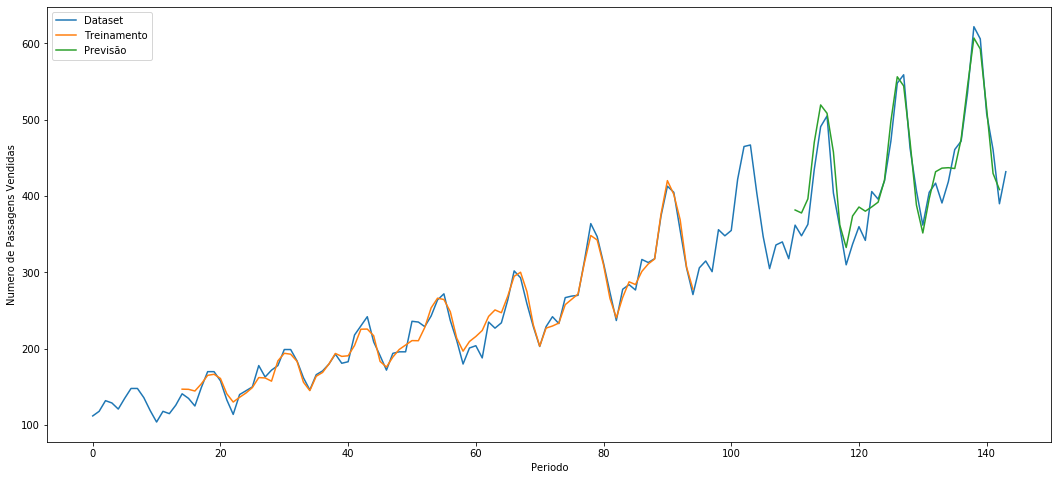

In [187]:
# realiza o plot dos dados de previsão e o real
plt.plot(scaler.inverse_transform(dataset), label = 'Dataset')
plt.plot(trainPredictPlot, label = 'Treinamento')
plt.plot(testPredictPlot, label = 'Previsão')
plt.xlabel('Periodo')
plt.ylabel('Numero de Passagens Vendidas')
plt.legend()
plt.show()